## Import Libraries

Import all the required Libraries

In [315]:

import os
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

from sklearn.decomposition import PCA

from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout

In [316]:
import warnings
warnings.filterwarnings("ignore")

In [349]:
# Ablation Experiment
ablation = False
ablation_ratio = 0.15

# how many unique words to use (i.e num rows in embedding vector)
max_features = 120000
# Percentile of Padding to use with Tokenized words
pad_percentile = 50

# Use Keras Tokenizer
use_tokenizer = True
use_tf_idf = False

pca_components = 25

## Create Train and Test DF

Create Training and Testing Data Frames

In [318]:

#ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants'
ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants'
TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')


In [319]:

# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df


In [320]:
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

## EDA

Primilinary Exploratory Data Analysis

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [321]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

## NLTK Tokenization and Lemmatization

First, we need to remove the stop words, punctuation characters and all other special characters from the text.
Then, we need to lemmatize the word to it's root form.

In [322]:
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

stop_words = set(nltk.corpus.stopwords.words('english'))

# default tag is Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

lemma = WordNetLemmatizer()

words = train_df.loc[0, 'text']

def lemmatize(words):
    # Remove Stop words and keep only Alpha Numeric words
    words = [word for word in nltk.word_tokenize(words) if word.isalnum() and word.lower() not in stop_words]

    return ' '.join([lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(words)])

In [323]:
%%time

train_df['text'] = train_df['text'].apply(lemmatize)
test_df['text'] = test_df['text'].apply(lemmatize)

CPU times: user 5min 39s, sys: 348 ms, total: 5min 40s
Wall time: 5min 40s


In [324]:
def add_features(df):
    df['text'] = df['text'].apply(lambda x:str(x))
    df["lower_text"] = df["text"].apply(lambda x: x.lower())
    df['total_length'] = df['text'].apply(len)
    df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.text.str.count('\S+')
    df['num_unique_words'] = df['text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] 
    return df

train_df = add_features(train_df)
test_df = add_features(test_df)

In [325]:
train_df.to_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'), index = False)
test_df.to_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'), index = False)

In [326]:
train_df = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'))
test_df = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'))

In [327]:
to_drop = ['document_name', 'text']
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

## Util Functions

Some Utility Functions 

In [328]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [329]:
#set_no = get_set_from_word_list(train_df_temp)
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [330]:
def get_tf_idf(train_df, test_df):
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names() #pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()), X

## Ablation Experiment
Experimentation on a Smaller Dataset

In [331]:
if ablation:
    train_df_no = train_df[train_df.is_fitara == 0]
    train_df_yes = train_df[train_df.is_fitara == 1]

    # Get 15% of total Records for Ablation
    train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation_ratio)]
    train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation_ratio)]
    
    # Shuffle rows and reset index
    train_df = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

### Train Test Split

In [332]:
X = train_df.drop(['is_fitara'], axis=1)
y = train_df['is_fitara']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Tokenize the Strings

In [333]:
text_col = 'lower_text'

if use_tokenizer:
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train[text_col]))
    X_train[text_col] = tokenizer.texts_to_sequences(X_train[text_col])
    X_test[text_col] = tokenizer.texts_to_sequences(X_test[text_col])

### Pad the sentences 

In [334]:
# Find Max Length
train_max_len = np.percentile(X_train[text_col].apply(len), pad_percentile)
test_max_len = np.percentile(X_test[text_col].apply(len), pad_percentile)

max_len = int(test_max_len if train_max_len < test_max_len else train_max_len)

# Pad the Sentences
X_train_temp = pd.DataFrame(pad_sequences(X_train[text_col], maxlen=max_len), index = X_train.index)
X_test_temp = pd.DataFrame(pad_sequences(X_test[text_col], maxlen=max_len), index = X_test.index)

# Remove Existing DF
X_train.drop([text_col], axis=1, inplace=True)
X_test.drop([text_col], axis=1, inplace=True)

# Create new DF
X_train = pd.concat([X_train_temp, X_train], axis = 1)
X_test = pd.concat([X_test_temp, X_test], axis = 1)

### Standard Scaler Transformation

In [335]:
scaler = StandardScaler()

cols = X_train.columns
#cols = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique']

train_features = X_train[cols].values
test_features = X_test[cols].values

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

X_train[cols] = pd.DataFrame(train_features, columns = cols, index = X_train.index)
X_test[cols] = pd.DataFrame(test_features, columns = cols, index = X_test.index)

In [336]:
X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'), index = False)
X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'), index = False)

### Principle Component Analysis

In [354]:
pca = PCA(n_components = pca_components)

pca.fit(X_train)

X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))

print(f"Variance Explained by Model is {pca.explained_variance_ratio_.cumsum()}")

ValueError: n_components=25 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

### Model Building

In [347]:
%%time
# X_train, X_test, feature_names = get_tf_idf(X_train_split['text'], X_test_split['text'])

# build pipeline
vectorizer = TfidfVectorizer()
regressor = SVC()

pipeline = Pipeline([('Logistic Regression', BernoulliNB(alpha=.01))])

# fit pipeline
pipeline.fit(X_train, y_train)

# predict
y_pred = pipeline.predict(X_test)

print(metrics.log_loss(y_test.values, y_pred))
print(y_pred)
print(y_test.values)


11.994748232187376
[1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1
 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1]
CPU times

In [348]:
%%time

#X_train_lr, X_test_lr, _ = get_tf_idf(X_train, X_test)
#model = SVC(kernel='linear', C=100, probability=True, random_state=32)
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

print(metrics.log_loss(y_test.values, y_pred))
print(y_pred)
print(y_test.values)

9.971449250402792
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1
 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1]
CPU times:

In [340]:
# create model
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# train model
history = model.fit(X_train, to_categorical(y_train, 2), epochs=400, batch_size=10, verbose=2)#, class_weight={1:0.96, 0:0.04})

Epoch 1/400
 - 0s - loss: 0.6557 - acc: 0.6075
Epoch 2/400
 - 0s - loss: 0.5881 - acc: 0.7067
Epoch 3/400
 - 0s - loss: 0.5837 - acc: 0.7137
Epoch 4/400
 - 0s - loss: 0.5861 - acc: 0.6997
Epoch 5/400
 - 0s - loss: 0.5816 - acc: 0.7165
Epoch 6/400
 - 0s - loss: 0.5850 - acc: 0.7137
Epoch 7/400
 - 0s - loss: 0.5732 - acc: 0.7151
Epoch 8/400
 - 0s - loss: 0.5740 - acc: 0.7221
Epoch 9/400
 - 0s - loss: 0.5682 - acc: 0.7221
Epoch 10/400
 - 0s - loss: 0.5708 - acc: 0.7291
Epoch 11/400
 - 0s - loss: 0.5635 - acc: 0.7193
Epoch 12/400
 - 0s - loss: 0.5616 - acc: 0.7249
Epoch 13/400
 - 0s - loss: 0.5605 - acc: 0.7207
Epoch 14/400
 - 0s - loss: 0.5620 - acc: 0.7277
Epoch 15/400
 - 0s - loss: 0.5564 - acc: 0.7318
Epoch 16/400
 - 0s - loss: 0.5552 - acc: 0.7374
Epoch 17/400
 - 0s - loss: 0.5439 - acc: 0.7388
Epoch 18/400
 - 0s - loss: 0.5560 - acc: 0.7402
Epoch 19/400
 - 0s - loss: 0.5606 - acc: 0.7416
Epoch 20/400
 - 0s - loss: 0.5593 - acc: 0.7402
Epoch 21/400
 - 0s - loss: 0.5510 - acc: 0.7402
E

Epoch 171/400
 - 0s - loss: 0.4401 - acc: 0.8128
Epoch 172/400
 - 0s - loss: 0.4342 - acc: 0.8003
Epoch 173/400
 - 0s - loss: 0.4407 - acc: 0.8017
Epoch 174/400
 - 0s - loss: 0.4308 - acc: 0.8101
Epoch 175/400
 - 0s - loss: 0.4382 - acc: 0.8212
Epoch 176/400
 - 0s - loss: 0.4328 - acc: 0.8128
Epoch 177/400
 - 0s - loss: 0.4157 - acc: 0.8212
Epoch 178/400
 - 0s - loss: 0.4176 - acc: 0.8226
Epoch 179/400
 - 0s - loss: 0.4241 - acc: 0.8184
Epoch 180/400
 - 0s - loss: 0.4124 - acc: 0.8156
Epoch 181/400
 - 0s - loss: 0.4262 - acc: 0.8128
Epoch 182/400
 - 0s - loss: 0.4272 - acc: 0.8156
Epoch 183/400
 - 0s - loss: 0.4191 - acc: 0.8198
Epoch 184/400
 - 0s - loss: 0.4064 - acc: 0.8296
Epoch 185/400
 - 0s - loss: 0.4169 - acc: 0.8198
Epoch 186/400
 - 0s - loss: 0.4183 - acc: 0.8254
Epoch 187/400
 - 0s - loss: 0.4306 - acc: 0.8128
Epoch 188/400
 - 0s - loss: 0.4135 - acc: 0.8142
Epoch 189/400
 - 0s - loss: 0.4308 - acc: 0.8170
Epoch 190/400
 - 0s - loss: 0.4076 - acc: 0.8184
Epoch 191/400
 - 0s 

 - 0s - loss: 0.3509 - acc: 0.8394
Epoch 339/400
 - 0s - loss: 0.3522 - acc: 0.8436
Epoch 340/400
 - 0s - loss: 0.3548 - acc: 0.8506
Epoch 341/400
 - 0s - loss: 0.3378 - acc: 0.8520
Epoch 342/400
 - 0s - loss: 0.3413 - acc: 0.8422
Epoch 343/400
 - 0s - loss: 0.3400 - acc: 0.8478
Epoch 344/400
 - 0s - loss: 0.3413 - acc: 0.8464
Epoch 345/400
 - 0s - loss: 0.3301 - acc: 0.8631
Epoch 346/400
 - 0s - loss: 0.3445 - acc: 0.8422
Epoch 347/400
 - 0s - loss: 0.3396 - acc: 0.8506
Epoch 348/400
 - 0s - loss: 0.3445 - acc: 0.8464
Epoch 349/400
 - 0s - loss: 0.3462 - acc: 0.8450
Epoch 350/400
 - 0s - loss: 0.3370 - acc: 0.8492
Epoch 351/400
 - 0s - loss: 0.3380 - acc: 0.8506
Epoch 352/400
 - 0s - loss: 0.3539 - acc: 0.8506
Epoch 353/400
 - 0s - loss: 0.3276 - acc: 0.8547
Epoch 354/400
 - 0s - loss: 0.3225 - acc: 0.8575
Epoch 355/400
 - 0s - loss: 0.3368 - acc: 0.8492
Epoch 356/400
 - 0s - loss: 0.3355 - acc: 0.8450
Epoch 357/400
 - 0s - loss: 0.3595 - acc: 0.8394
Epoch 358/400
 - 0s - loss: 0.3334

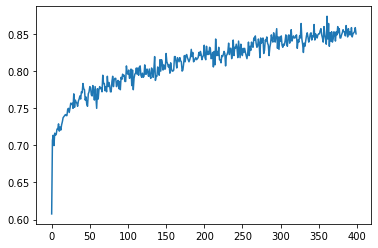

In [341]:
# plot metrics
plt.plot(history.history['acc'])
plt.show()

In [342]:
#print(y_test.values)
#print(pred)
#print(pred_proba)

num = metrics.log_loss(y_test.values, model.predict(X_test))


#math.exp(-num)
print(num)
print(math.exp(-num))
print(y_test.values)
print(np.round(model.predict(X_test)))

0.7756504627864294
0.46040420777503815
[1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1
 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.

Decision Tree 

Random Forest 



In [343]:
terminate

NameError: name 'terminate' is not defined

In [ ]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.log_loss(y_test, pred)
    print("accuracy:   %0.3f" % score)
    """
    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        #if opts.print_top10 and feature_names is not None:
        print("top 10 keywords per class:")
        for i, label in enumerate(target_names):
            top10 = np.argsort(clf.coef_[i])[-10:]
            print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()
    """
    #if opts.print_report:
    print("classification report:")
    print(metrics.classification_report(y_test, pred))

    #if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [ ]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

In [ ]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

In [ ]:
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()